In [1]:
from collections import defaultdict
from math import isclose
import time
from itertools import combinations

import networkx as nx
from scipy.sparse import linalg as scp_sla
import numpy as np
import matplotlib.pyplot as plt
import community as community_louvain

import sim_lib.util as util
import sim_lib.attr_lib.util as alu
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
def get_component_sizes(G):
    G_nx = alu.graph_to_nx(G)
    G_nx_comp_nodes = list(nx.connected_components(G_nx))
    G_nx_largest = G_nx.subgraph(max(G_nx_comp_nodes, key=len))
    G_nx_comps = [ G_nx.subgraph(G_nxc_nodes) for G_nxc_nodes in G_nx_comp_nodes ]
    component_sizes = [ len(G_nxc) for G_nxc in G_nx_comps ]
    return component_sizes

def find_holes_components(G):
    holes = []
    curr_num_components = len(get_component_sizes(G))
    for v in G.vertices:
        nbors = v.nbors
        for u in nbors:
            G.remove_edge(u,v)
        new_num_components = len(get_component_sizes(G)) - 1
        if new_num_components > curr_num_components:
            holes.append(v)
        for u in nbors:
            G.add_edge(u,v)
    return holes

def get_hole_borders(G):
    holes = find_holes_components(G)
    borders = []
    for v in G.vertices:
        if v in holes:
            borders = borders + [8]
        else:
            borders = borders + [0]
    return borders

def get_edge_types(G):
    edge_types = []
    G_nx = alu.graph_to_nx(G)
    for (u, v) in G_nx.edges():
        if u.data['struct'] == v.data['struct']:
            edge_types = edge_types + ['black']
        else:
            edge_types = edge_types + ['saddlebrown']
    return edge_types

def num_edges(G):
    return np.sum(G.adj_matrix) / 2
    #return G.edge_count

def count_stable_triads(G):
    num_stable_triad = 0
    num_em_ho_st = 0
    num_sc_ho_st = 0
    num_sc_he_st = 0
    for triad in combinations(G.vertices, 3):
        attr_funcs = [ t.data['attr'] for t in triad ]
        if len(set(attr_funcs)) != 1:
            continue
            
        struct_funcs = [ t.data['struct'] for t in triad ]
        if len(set(struct_funcs)) != 1:
            continue
          
        if triad[0].data['struct'] == 'em' and triad[0].data['attr'] == 'ho':
            
            # Homophily so all same type
            if len(set([ t.data['type_name'] for t in triad ])) != 1:
                continue
                
            # Triangle
            if G.are_neighbors(triad[0], triad[1]) and G.are_neighbors(triad[0], triad[2]) \
                    and G.are_neighbors(triad[1], triad[2]):
                num_em_ho_st += 1
        elif triad[0].data['struct'] == 'sc' and triad[0].data['attr'] == 'ho':
            
            # Homophily all same type
            if len(set([ t.data['type_name'] for t in triad ])) != 1:
                continue
                
            # Exactly two edges
            if sum([ G.are_neighbors(p[0], p[1]) for p in combinations(triad, 2) ]) == 2:
                num_sc_ho_st += 1
        elif triad[0].data['struct'] == 'sc' and triad[0].data['attr'] == 'he':
            
            # Heterophily so not all same type
            if len(set([ t.data['type_name'] for t in triad ])) == 1:
                continue
                
            # Exactly two edges
            edge_pairs = []
            for pair in combinations(triad, 2):
                if G.are_neighbors(pair[0], pair[1]):
                    edge_pairs.append(pair)
            
            if len(edge_pairs) != 2:
                continue
            if edge_pairs[0][0].data['type_name'] != edge_pairs[0][1].data['type_name'] and \
                    edge_pairs[1][0].data['type_name'] != edge_pairs[1][1].data['type_name']:
                num_sc_he_st += 1
                
    return num_em_ho_st + num_sc_ho_st + num_sc_he_st

def is_nondec(arr):
    n = len(arr)
    for i in range(n-1):
        if arr[i+1] < arr[i]:
            return False
    return True

In [3]:
_N = 100
clique_size = 10
satisfice = 1.0

# Embedded likelihood = (1 - sc_likelihood)
sc_likelihood = 0.0

# Heterophily likelihood = (1 - ho_likelihood)
ho_likelihood = 1.0

# Simul + some vis parameters
num_iters = 50
add_to_iter = 0
show_last = 0
show_every = 0
log_last = 0
log_every = 0

similarity_homophily, similarity_heterophily = alu.gen_similarity_funcs()
total_attr_util = alu.gen_attr_util_func(satisfice)

# Create types
def type_dict(context, shape, context_p, attr, struct):
    likelihood = context_p
    if struct == 'em':
        struct_func = alu.satisfice(satisfice)(alu.triangle_count)
        likelihood = likelihood * (1 - sc_likelihood)
    else:
        struct_func = alu.satisfice(satisfice)(alu.num_disc_nbors)
        likelihood = likelihood * sc_likelihood
    if attr == 'ho':
        attr_edge_func = similarity_homophily
        likelihood = likelihood * ho_likelihood
    else:
        attr_edge_func = similarity_heterophily
        likelihood = likelihood * (1 - ho_likelihood)
        
    attr_total_func = total_attr_util
    
    #Base color is a rgb list
    base_dict = {'likelihood' : likelihood,
              'struct_util' : struct_func,
              'struct' : struct,
              'init_attrs' : context,
              'attr' : attr,
              'edge_attr_util' : attr_edge_func,
              'total_attr_util' : attr_total_func,
              'optimistic' : False,
              'shape' :  shape
              }

    return base_dict

ctxt_types = [-1, 1]
ctxt_base_shapes = [0 , 2]
ctxt_p = [0.5, 0.5]
assert(isclose(sum(ctxt_p), 1.0), 'Context likelihood needs to sum to 1')
struct_types = ['em', 'sc']
attr_types = ['ho', 'he']
type_itr = [ (ctxt, shape, ct_p, at, st) for (ctxt, shape, ct_p) in zip(ctxt_types, ctxt_base_shapes, ctxt_p)
            for (at, st) in [(a, s) for a in attr_types for s in struct_types] ]
type_list = [ type_dict(*t_args) for t_args \
              in type_itr ]

type_counts = [ int(np.floor(_N * tl['likelihood'])) for tl in type_list ]

remaining_tc = _N - sum(type_counts)
for i in range(remaining_tc):
    type_counts[i] = type_counts[i] + 1
assert sum(type_counts) == _N, 'Did that work?'

tc_dict = { f'type{idx}' : tc for idx, tc in enumerate(type_counts) }
vtx_types = { f'type{idx}' : tl for idx, tl in enumerate(type_list) }

params = {
    'context_count' : 2, # Needed for simple utility
    'edge_selection' : alu.seq_projection_edge_edit,
    'seed_type' : 'trivial', # Type of seed network
    'max_clique_size' : clique_size,
    'revelation_proposals' : alu.indep_revelation,
    'util_agg' : alu.linear_util_agg, # How to aggregate utility values
    'vtx_types' : vtx_types
}

vtx_types_list = np.array([ np.repeat(t, tc) for t, tc in tc_dict.items() ])
vtx_types_list = np.hstack(vtx_types_list)
np.random.shuffle(vtx_types_list)

# Assign types to vertices before intialization
params['type_assignment'] = { i : vtx_types_list[i] for i in range(_N) }

assert isclose(sum([ t['likelihood'] for t in params['vtx_types'].values() ]), 1.0)

<>:57: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:57: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_2490/1482666718.py:57: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(isclose(sum(ctxt_p), 1.0), 'Context likelihood needs to sum to 1')
/tmp/ipykernel_2490/1482666718.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vtx_types_list = np.array([ np.repeat(t, tc) for t, tc in tc_dict.items() ])


Initial graph
it # 0
it # 1
it # 2
it # 3
it # 4
it # 5
it # 6
it # 7
it # 8
it # 9
it # 10
it # 11
it # 12
it # 13
it # 14
it # 15
it # 16
it # 17
it # 18
it # 19
it # 20
it # 21
it # 22
it # 23
it # 24
it # 25
it # 26
it # 27
it # 28
it # 29
it # 30
it # 31
it # 32
it # 33
it # 34
it # 35
it # 36
it # 37
it # 38
it # 39
it # 40
it # 41
it # 42
it # 43
it # 44
it # 45
it # 46
it # 47
it # 48
it # 49


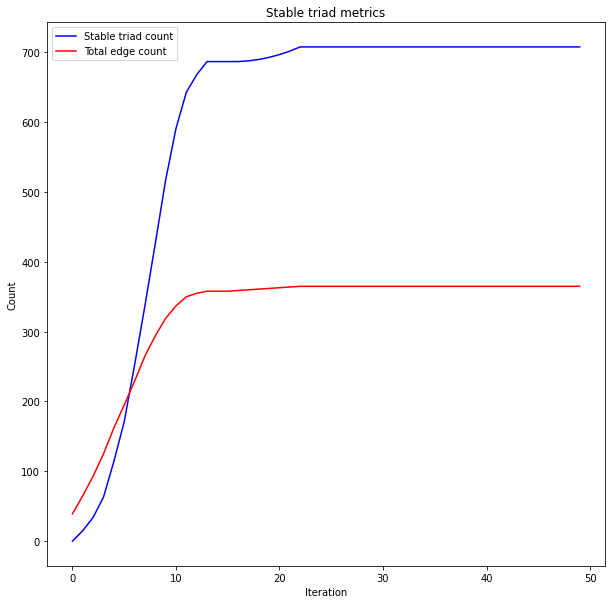

'\nplt.figure(figsize=(10,10))\nx_vals = list(range(num_iters))\nplt.xlabel("Iteration")\nplt.ylabel("Value")\nplt.title("Vertex property summary stats")\nfor si in range(len(stat_val_colors)):\n    for fi in range(len(summary_func_styles)):\n        plt.plot(x_vals,\n                 summary_stats[summary_stat_vals[si]][summary_func_names[fi]],\n                 color=stat_val_colors[si],\n                 linestyle=summary_func_styles[fi],\n                 label=\'{0} {1}\'.format(summary_func_names[fi], summary_stat_vals[si]))\nplt.legend()\n\nplt.figure(figsize=(10,10))\n\nplt.show()\n'

In [4]:
G = attribute_network(_N, params)
#print(G.sim_params)

summary_stat_vals = ['alu', 'struct_util', 'cost']
summary_funcs = [ min, max, np.median ]
summary_func_names = ['min', 'max', 'median']
summary_stats = { val : { name : [] for name in summary_func_names } \
                 for val in summary_stat_vals }
stat_val_colors = ['green', 'gold', 'rebeccapurple']
summary_func_styles = ['-', '--', ':']

st_counts = []
edge_counts = []

print('Initial graph')
#vis.graph_vis(G, 'test', 'again')
for it in range(num_iters):
    if it < add_to_iter:
        add_attr_graph_vtx(G)
        
    meets_log = (log_every != 0) and ((it % log_every == 0) or (it >= num_iters - log_last))
    if meets_log:
        G.sim_params['edge_selection'] = alu.seq_edge_sel_logged
    else:
        G.sim_params['edge_selection'] = alu.seq_edge_sel_silent
    
    print('it #', it)
    
    pre_ce_time = time.time()
    calc_edges(G)
    post_ce_time = time.time()
        
    # Sim iter end, start stat collection
    attr_util_vals = [ u.data['total_attr_util'](u, G) for u in G.vertices ]
    struct_util_vals = [ u.data['struct_util'](u, G) for u in G.vertices ]
    costs = [ alu.calc_cost(u, G) for u in G.vertices ]
    values = [attr_util_vals, struct_util_vals, costs]
    
    st_counts.append(count_stable_triads(G))
    edge_counts.append(num_edges(G))
    
    for si in range(len(summary_stat_vals)):
        for fi in range(len(summary_funcs)):
            ss_val = summary_funcs[fi](values[si])
            summary_stats[summary_stat_vals[si]][summary_func_names[fi]].append(ss_val)
            
    if show_every > 0 and (it % show_every == 0 or it >= num_iters - show_last):
        ind_ob = lambda v : 1 if alu.remaining_budget(v, G) < 0 else 0
        sat_ob = lambda v : 1 if G.sim_params['util_agg'](
            v.data['total_attr_util'](v, G),
            v.data['struct_util'](v, G),
            alu.calc_cost(v, G),
            v, G
        ) == 2.0 else 0
        print('num over budget', sum([ind_ob(v) for v in G.vertices]))
        print('num sat', sum([sat_ob(v) for v in G.vertices]))
        partition = community_louvain.best_partition(alu.graph_to_nx(G))
        vis.graph_vis(G, 'test', 'it # ' + str(it), partition, get_edge_types(G), get_hole_borders(G), save=False)

plt.figure(figsize=(10,10))
x_vals = list(range(num_iters))
plt.xlabel("Iteration")
plt.ylabel("Count")
plt.title("Stable triad metrics")
plt.plot(x_vals,
         st_counts,
        color='b',
        label='Stable triad count')
plt.plot(x_vals,
         edge_counts,
         color='r',
         label='Total edge count')
plt.legend()
plt.show()

assert is_nondec(st_counts), 'Stable triad count should be nondecreasing'

"""
plt.figure(figsize=(10,10))
x_vals = list(range(num_iters))
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Vertex property summary stats")
for si in range(len(stat_val_colors)):
    for fi in range(len(summary_func_styles)):
        plt.plot(x_vals,
                 summary_stats[summary_stat_vals[si]][summary_func_names[fi]],
                 color=stat_val_colors[si],
                 linestyle=summary_func_styles[fi],
                 label='{0} {1}'.format(summary_func_names[fi], summary_stat_vals[si]))
plt.legend()

plt.figure(figsize=(10,10))

plt.show()
"""